In [1]:
try:
  import svg.path
except:
  !pip install svg.path

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from cmath import exp,pi
def turtlePath2Points(Segs,p0=0+0j,scale=1.0,a0=1+0j,tol=0.05,offs=0,loops=1,return_heading=False,return_start_point=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0/abs(a0)
  p=p0
  p-=1j*a*offs
  if return_start_point:
      if return_heading:
        yield p,a
      else:
        yield p
  for _ in range(loops):
      for l,da in Segs:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          if return_heading:
            yield p,a
          else:
            yield p
          v*=dda
          a*=dda


In [4]:
def polygon2TurtlePath(p,r=0,chamfer=False,max_cutoff_ratio=0.5,skip_cutoff=True):
  pnext=np.roll(p,-1) #the point ahead 
  v=pnext-p #vector to the point ahead
  l=abs(v)  #length of each side
  heading=v/l #heading as unit vector
  heading_change=np.roll(heading,-1)/heading
  tan_alpha2=abs(heading_change.imag/(heading_change.real+1))#sin(alpha/2)/cos(alpha/2)=sin(alpha)/(cos(alpha)+1)
  alpha=np.log(heading_change).imag #conversion of the heading vector change to radians
  alpha2=alpha/2
  calc_cutoff=np.ones_like(p,dtype=float)*r*tan_alpha2 #cutoffs based on desired radiuses
  max_cutoff=l*np.roll(max_cutoff_ratio,-1) #maximum allowable cutoff for each side
  used_cutoff=np.min([calc_cutoff,max_cutoff,np.roll(max_cutoff,1)],axis=0) #selected based on constraintd given
  r_used=used_cutoff/tan_alpha2 #the resulting radius calculated from selected cutoff length
  l=l-used_cutoff-np.roll(used_cutoff,1) #subtract the cutoff from both ends of each side
  secant_length=2*r_used*abs(np.sin(alpha2)) #calculate the secant length for the chamfer option
  if not skip_cutoff:
      yield (used_cutoff[-1],0) #straight line from first polygon point to start of turtle path
  for l,a,r,lsec,ch in zip(l,alpha,r_used,secant_length,np.zeros_like(p,dtype=bool)|chamfer):
      yield (l,0) #the straight portion of each polygon side
      if ch: #chamfer
        yield(0.0,a/2) 
        yield(lsec,0)
        yield(0.0,a/2)
      else:  #fillet
        yield (r*abs(a),a)

In [9]:
from xml.dom import minidom
from svg.path import parse_path
try:
  filename="test.svg"
  doc = minidom.parse(filename)#load local file
  print(f'{filename} loaded')
except:
  import requests
  import io
  url='https://raw.githubusercontent.com/RichardPotthoff/myrepo/master/test.svg'
  doc = minidom.parse(io.BytesIO(requests.get(url).content))
  print(f'{url} loaded')

path_index=1# pick the second path in the file

parsed_path=parse_path(doc.getElementsByTagName('path')[path_index].getAttribute('d'))
#only use the start points of segments with a length <>0
polygon=np.array([l.start.conjugate() for l in parsed_path if abs(l.start-l.end)>1e-6])#filter zero-length lines

test.svg loaded


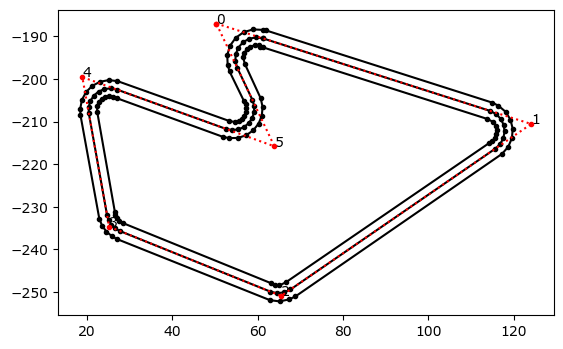

In [10]:
n=len(polygon)
loop=np.arange(n+1)%n#add last point to the end
plt.plot(polygon[loop].real,polygon[loop].imag,'r.:',zorder=5)
for i, p in enumerate(polygon):
    plt.annotate(f'{i}', (p.real, p.imag))
    pass
turtlePath=list(polygon2TurtlePath(polygon,
        r=5,
        skip_cutoff=False))
p0,p1=polygon[:2]
phs,headings=np.array(list(turtlePath2Points(turtlePath,p0=p0,a0=p1-p0,offs=0.0,tol=0.07,return_start_point=True,return_heading=True))).T
for offs in (-2,0,2):
  p=phs[1:]+1j*offs*headings[1:]
  plt.plot(p.real,p.imag,'k.-',zorder=1);
plt.gca().set_aspect('equal') 

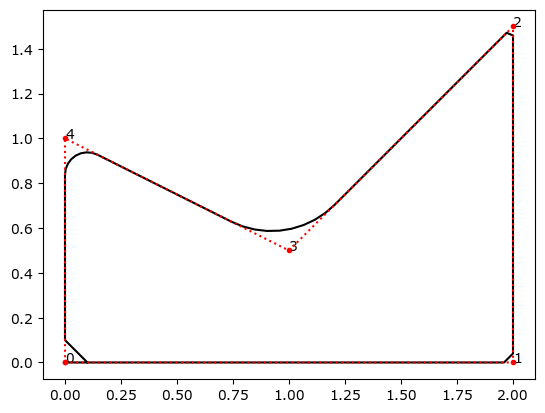

In [7]:
polygon=np.array([0+0j,2+0j,2+1.5j,1+0.5j,0+1j])
n=len(polygon)
loop=np.arange(n+1)%n#add last point to the end
plt.plot(polygon[loop].real,polygon[loop].imag,'r.:',zorder=5)
for i, p in enumerate(polygon):
    plt.annotate(f'{i}', (p.real, p.imag))
    pass
turtlePath=list(polygon2TurtlePath(polygon,
        r=np.array([0.1,0.1,0.4,0.1,0.1]),
        chamfer=[True,True,False,False,True],
        max_cutoff_ratio=np.array([0.5,0.02,0.5,0.5,0.5]),
        skip_cutoff=False))
p0,p1=polygon[:2]
phs=np.array(list(turtlePath2Points(turtlePath,p0=p0,a0=p1-p0,offs=0.0,tol=0.001,return_start_point=True) ))
plt.gca().set_aspect('equal') 
plt.plot(phs.real,phs.imag,'k-',zorder=1);